## Forecasts for Product Demand
### Background
- https://www.kaggle.com/datasets/felixzhao/productdemandforecasting?resource=download
- The dataset contains historical product demand for a manufacturing company with footprints globally. 
- The company provides thousands of products within dozens of product categories. 
- There are four central warehouses to ship products within the region it is responsible for. 
- Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. 
- If forecasts for each product in different central with reasonable accuracy for the **monthly demand for month after next** can be achieved, it would be beneficial to the company in multiple ways.

In [1]:
import logging
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from lightgbm import LGBMRegressor

sns.set_style('darkgrid')
sns.set_palette("bright")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [5]:
import check_numeric

In [2]:
file_name = "data/Historical Product Demand.csv"        
start_date = '2012-01-01'
end_date = '2016-12-31'

In [21]:
def load_data(file_name, start_date, end_date):

    """
    데이터 불러와서 타깃의 값이 수치형 아닌 경우 제거
    """
    df = pd.read_csv(file_name)
    df.columns = ['prd_code', 'warehouse', 'category', 'date', 'order']

    # 수치형이 아닌 경우 제거
    df['is_num'] = df.order.apply(_check_if_numeric)
    df = df.query("is_num == True").drop('is_num', axis=1)

    # datetime, int 형태로 컬럼 타입을 변환
    df['date'] = pd.to_datetime(df['date'])
    df.rename(columns={'date':'target_date'}, inplace=True)

    # monthly prediction을 위해 YYYY-MM 형태로 변환
    df['order'] = df['order'].astype(int)    

    # 비정상 데이터 제거
    df = df.query("target_date >= @start_date and target_date <= @end_date")
    df['month'] = df['target_date'].dt.month
    df['day'] = df['target_date'].dt.dayofweek    
    df['day_name'] = df['target_date'].dt.day_name()
    
    return df  

In [22]:
df = load_data(file_name, start_date, end_date)

In [24]:
df

,prd_code,warehouse,category,target_date,order,month,day,day_name
0,Product_0993,Whse_J,Category_028,2012-07-27,100,7,4,Friday
1,Product_0979,Whse_J,Category_028,2012-01-19,500,1,3,Thursday
2,Product_0979,Whse_J,Category_028,2012-02-03,500,2,4,Friday
3,Product_0979,Whse_J,Category_028,2012-02-09,500,2,3,Thursday
4,Product_0979,Whse_J,Category_028,2012-03-02,500,3,4,Friday
...,...,...,...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016-04-27,1000,4,2,Wednesday
1048571,Product_1974,Whse_J,Category_006,2016-04-27,1,4,2,Wednesday
1048572,Product_1787,Whse_J,Category_006,2016-04-28,2500,4,3,Thursday
1048573,Product_0901,Whse_J,Category_023,2016-10-07,50,10,4,Friday


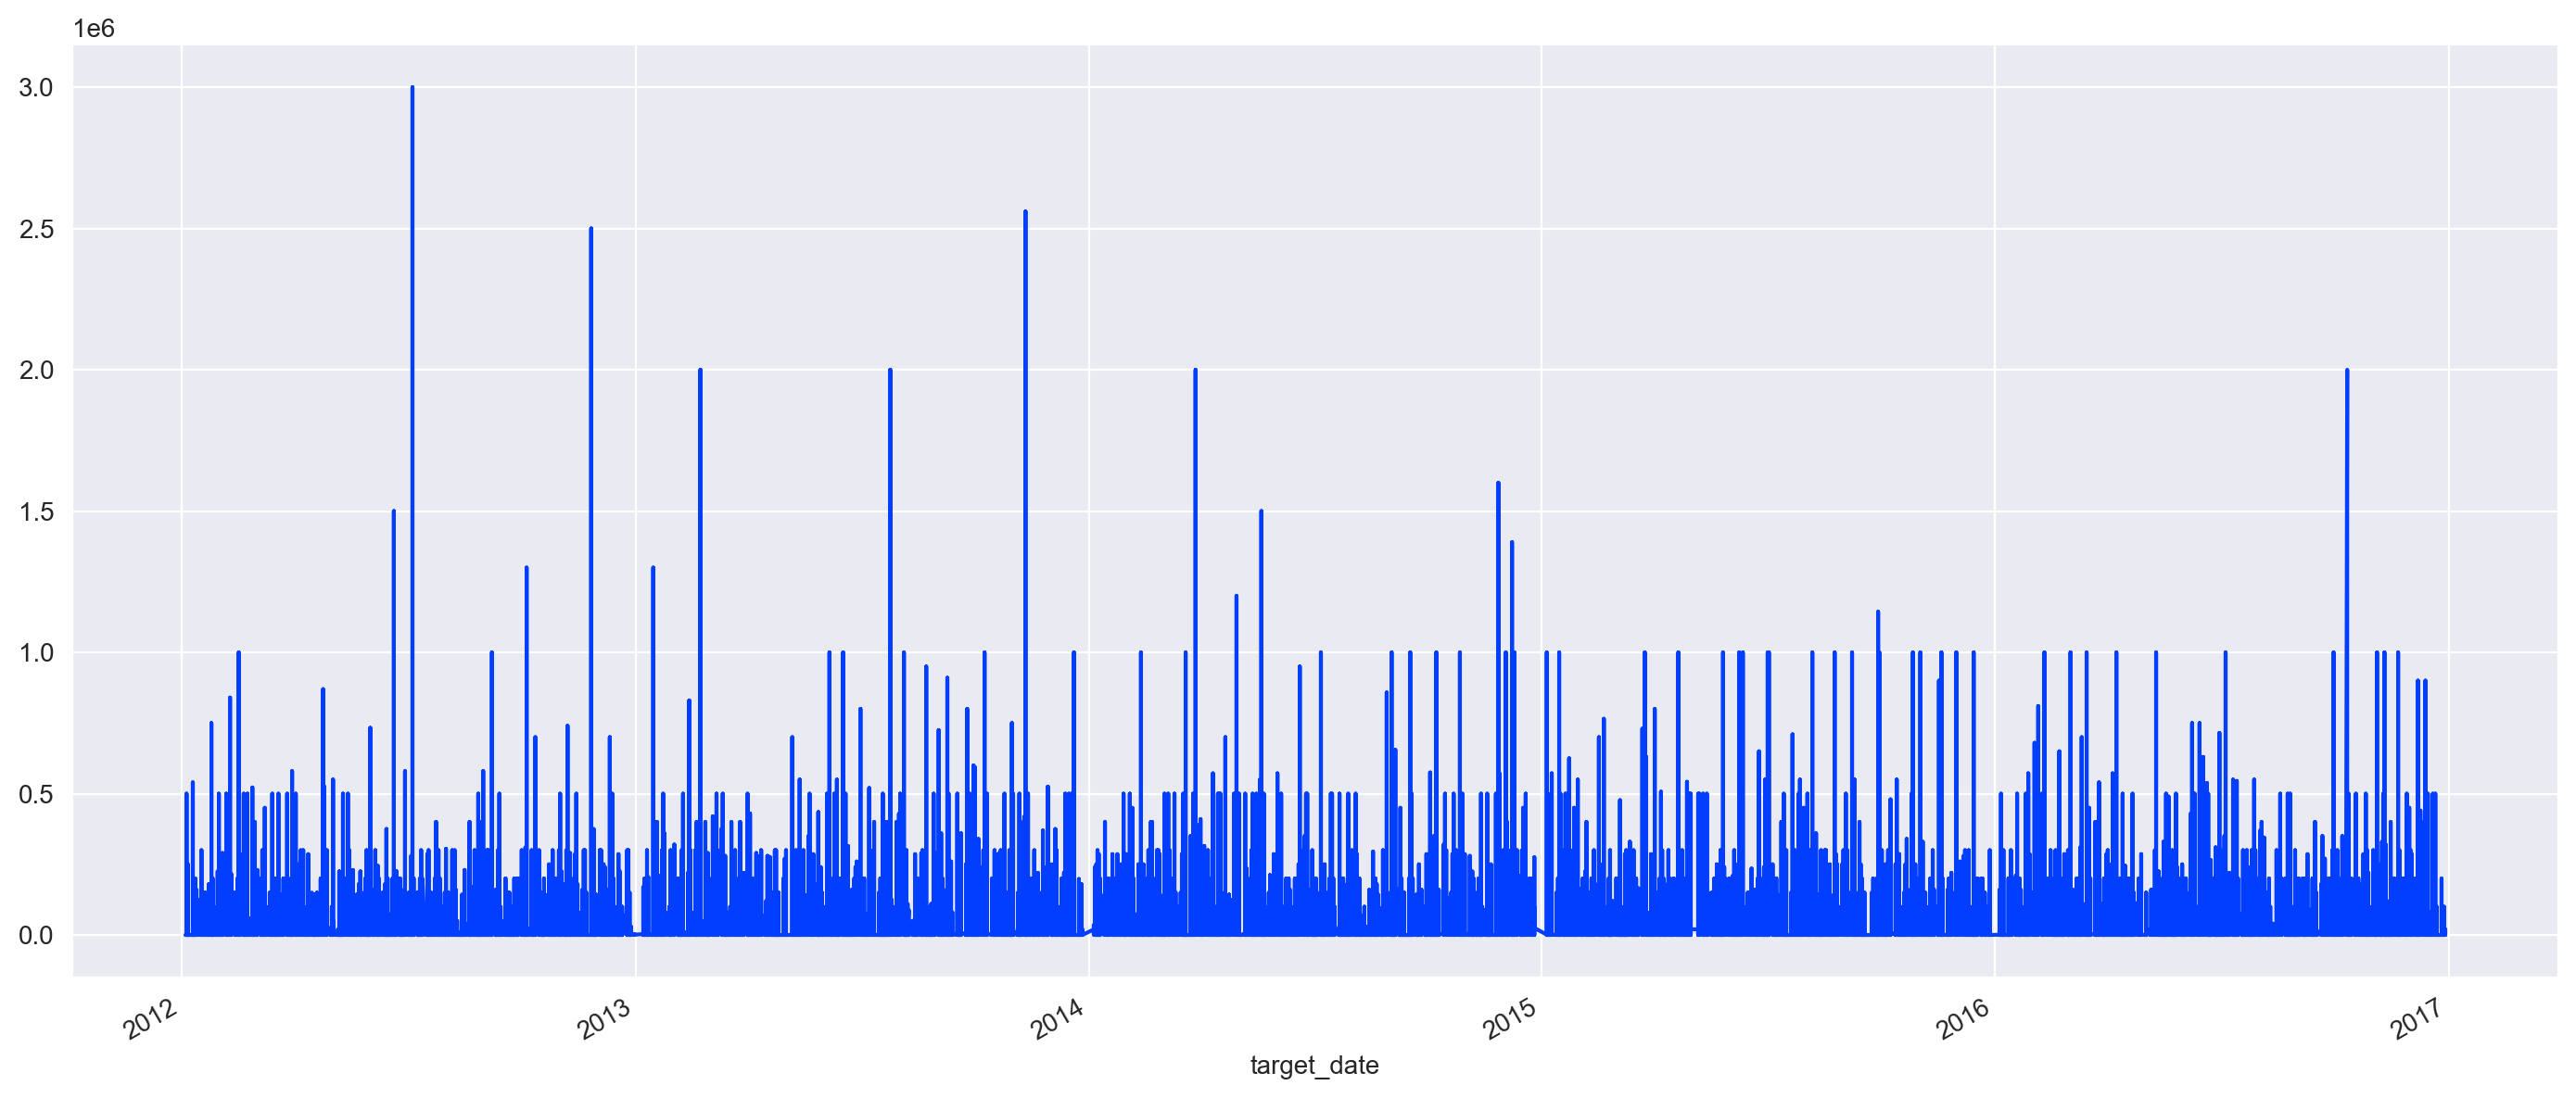

In [32]:
df.query("warehouse == 'Whse_J'").set_index("target_date").order.plot(figsize=(14,6))
plt.tight_layout()

In [19]:
df.groupby("warehouse").order.describe().astype(int)

,count,mean,std,min,25%,50%,75%,max
warehouse,,,,,,,,
Whse_A,140382,1035,4276,0,3,50,600,345200
Whse_C,42090,13789,59246,0,100,1000,6000,3000000
Whse_J,760668,4408,21188,0,25,300,2000,3000000
Whse_S,87644,11770,64893,0,30,500,4000,4000000


In [14]:
df.groupby(["warehouse"])[['category', 'prd_code']].nunique()

,category,prd_code
warehouse,,
Whse_A,25,427
Whse_C,16,244
Whse_J,25,1625
Whse_S,28,553


In [15]:
df.groupby(["warehouse", "month"]).order.mean().unstack().astype(int)

month,1,2,3,4,5,6,7,8,9,10,11,12
warehouse,,,,,,,,,,,,
Whse_A,1091,1085,1077,1079,1045,1022,1078,1089,993,736,1043,1263
Whse_C,13914,15359,15118,13866,13442,13323,14921,13057,12829,14704,12457,13092
Whse_J,4426,4178,4251,4441,4543,4472,4505,4337,4354,4362,4483,4581
Whse_S,13176,11519,13451,11049,12423,12145,12407,11261,9603,11762,10926,11421


In [27]:
df.groupby(["warehouse", "day_name"]).order.mean().unstack().astype(int)

day_name,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
warehouse,,,,,,,
Whse_A,991,992,335,1985,1068,1090,1013
Whse_C,12354,13685,41008,44655,14869,13374,13791
Whse_J,4523,4302,3552,4935,4496,4450,4258
Whse_S,13489,16417,7657,12149,8687,13571,5954


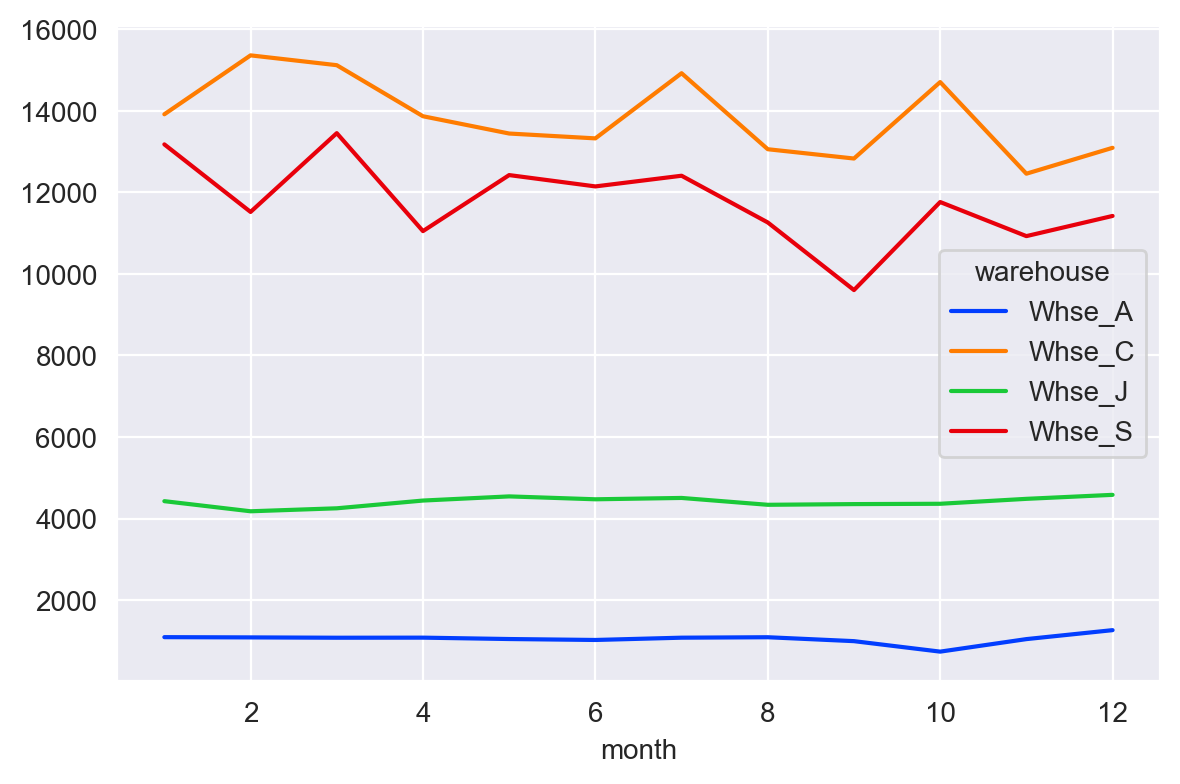

In [17]:
df.groupby(['month', 'warehouse']).order.mean().unstack().astype(int).plot(figsize=(6,4))
plt.tight_layout()

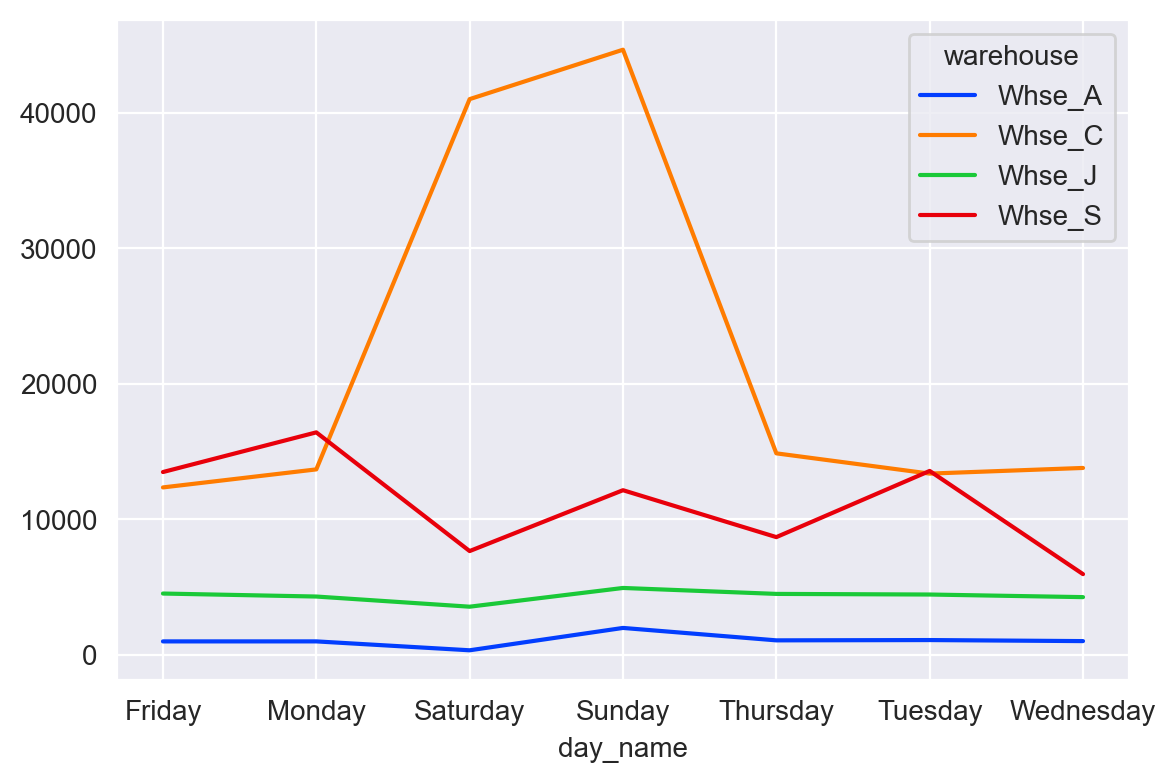

In [28]:
df.groupby(['day_name', 'warehouse']).order.mean().unstack().astype(int).plot(figsize=(6,4))
plt.tight_layout()

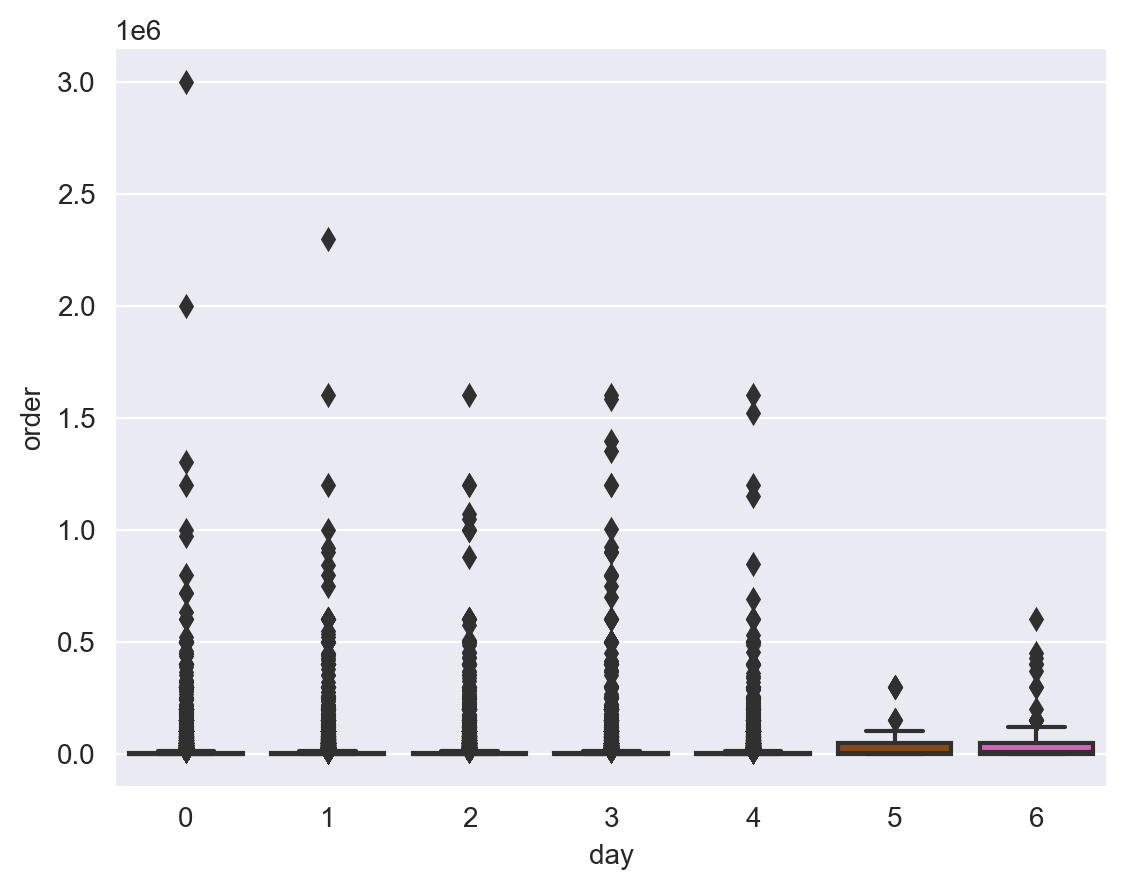

In [34]:
_df = df.query("warehouse == 'Whse_C'")
sns.boxplot(x="day", y="order", data=_df)
plt.show()